In [4]:
from sklearn.datasets import load_digits
from sklearn import cross_validation
import numpy as np
import pylab as plt
%matplotlib inline

/Users/lucasmoeller/anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1) Data preparation

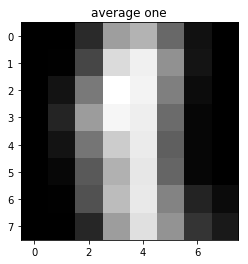

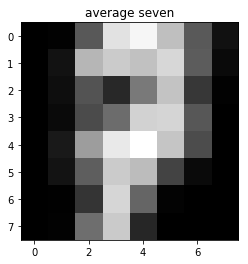

/Users/lucasmoeller/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(64, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/lucasmoeller/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(64, 15) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


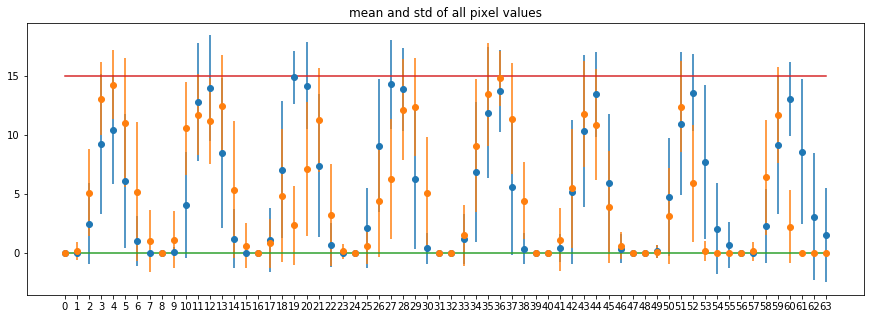

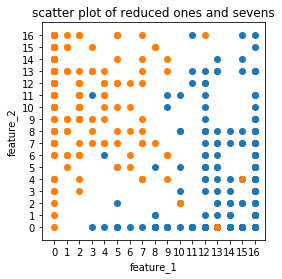

In [44]:
#plotting 64, array as (8,8) gray picture
def image_show(data, title):
    data.shape = (8,8)
    plt.gray()
    plt.imshow(data)
    plt.title(title)
    plt.show()
    return

#reducing 1d array to two features in seperate arrays
def reduce_dim(data, feat_1, feat_2):
    return data[:, feat_1], data[:, feat_2]

#scatter plotting arbitrary number of classes in 2d feature space
def plot_2d_data(title, *data):
    fig = plt.figure(figsize=(4, 4))
    for cla in data:
        plt.scatter(cla[0], cla[1])
    plt.xlabel('feature_1')
    plt.ylabel('feature_2')
    plt.xticks(range(17))
    plt.yticks(range(17))
    plt.title(title)
    plt.show()
    return

def extract_class(features, labels, cla):
    return features[np.where(labels==cla)]

#loading data set
digits = load_digits()

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

x_all = data
y_all = target

#splitting data
x_train, x_test, y_train, y_test = \
    cross_validation.train_test_split(data, target, \
                                     test_size=0.4, random_state=0)

#extracting images of ones and sevens
x_ones = x_all[np.where(y_all==1)]
x_sevens = x_all[np.where(y_all==7)]

#computing average one and seven picture
average_one = np.mean(x_ones, 0)
average_seven = np.mean(x_sevens, 0)

#plotting average pictures
image_show(average_one, 'average one')
image_show(average_seven, 'average seven')

#computing standard deviations of all features in and plotting them together with mean to 
#make a choice which features to chose
std_ones = np.std(x_ones, 0)
std_sevens = np.std(x_sevens, 0)
features = np.arange(64)

fig = plt.figure(figsize=(15,5))
plt.errorbar(features, average_one.reshape(64), yerr=std_ones, fmt='o')
plt.errorbar(features, average_seven.reshape(64), yerr=std_sevens, fmt='o')
#saturation boundaries
plt.plot(features, np.full(len(features), 0))
plt.plot(features, np.full(len(features), 15))
plt.xticks(range(64))
plt.title('mean and std of all pixel values')
plt.show()
    
#performing dimension reduction on ones and sevens
ones_feat_1, ones_feat_2 = reduce_dim(x_ones, 60, 10)
sevens_feat_1, sevens_feat_2 = reduce_dim(x_sevens, 60, 10)

#plotting data
plot_2d_data('scatter plot of reduced ones and sevens', \
             [ones_feat_1, ones_feat_2],[sevens_feat_1, sevens_feat_2])

# 2) Nearest Mean Classifier

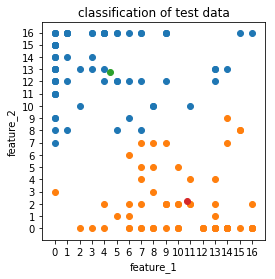

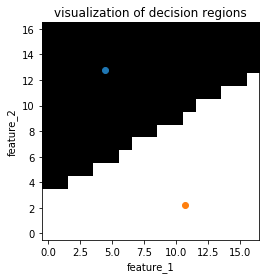

In [47]:
from scipy.spatial import distance

#takes unprocessed features and labels, extracts instances of extraction_class,
#reduces dimension to feat1 and feat2 and splits into test and training set 
#according to test_proportion
#returns two np arrays for training and test of the form: 1st dim: features, 2nd dim: instances
def prepare_data(features, labels, extraction_class, feat1, feat2, test_proportion):
    x_class = features[np.where(labels==extraction_class)]
    x_red_feat1, x_red_feat2 = reduce_dim(x_class, feat1, feat2)
    x_train_feat1, x_test_feat1 = cross_validation.train_test_split(x_red_feat1,\
                                        test_size=test_proportion, random_state=0)
    x_train_feat2, x_test_feat2 = cross_validation.train_test_split(x_red_feat2,\
                                        test_size=test_proportion, random_state=0)
    return np.array([x_train_feat1, x_train_feat2]), np.array([x_test_feat1, x_test_feat2])

#takes list of np arrays as produced by prepare_data as training_data. training_labels must be a
#1d array with a label for each class.
#test_data is 2d np array, first dimension: features, second dimension: instances
def nearest_mean(training_data, training_labels, test_data):
    #calculate means
    means = np.empty((len(training_data), 2))
    for i in range(len(training_data)):
        for j in range(2):
            means[i, j] = np.mean(training_data[i][j])
    #classification on distance to means
    test_labels = np.empty(len(test_data[0]))
    for i in range(len(test_data[0])):
        test_point = np.array([test_data[0,i], test_data[1,i]])
        dist0 = distance.euclidean(means[0], test_point)
        dist1 = distance.euclidean(means[1], test_point)
        if dist0 < dist1:
            test_labels[i] = training_labels[0]
        else:
            test_labels[i] = training_labels[1]
    #split test_data according to classification
    test_labels0 = np.array([test_data[0][np.where(test_labels==training_labels[0])], \
                           test_data[1][np.where(test_labels==training_labels[0])]])
    test_labels1 = np.array([test_data[0][np.where(test_labels==training_labels[1])], \
                           test_data[1][np.where(test_labels==training_labels[1])]])
    return means, test_labels0, test_labels1

def visualize_classifier(title, means):
    #make 17x17 grid. sufficient because pixel values only take integers in [0,16]
    grid = np.zeros((17, 17))
    for i in range(17):
        for j in range(17):
            pixel = np.array([j, i])
            dist0 = distance.euclidean(means[0], pixel)
            dist1 = distance.euclidean(means[1], pixel)
            if dist0 > dist1:
                grid[i, j] = 1
    #plotting 
    fig = plt.figure(figsize=(4,4))
    plt.scatter(means[0,0], means[0,1])
    plt.scatter(means[1,0], means[1,1])
    plt.title(title)
    plt.xlabel('feature_1')
    plt.ylabel('feature_2')
    plt.imshow(grid, origin='lower')
    plt.show()
    return
     
ones_train, ones_test = prepare_data(x_all, y_all, 1, 10, 60, 0.4)
sevens_train, sevens_test = prepare_data(x_all, y_all, 7, 10, 60, 0.4)
test_data = np.concatenate((ones_test, sevens_test), axis=1)
training_labels = np.array([1, 7])

means, test_labels0, test_labels1 = nearest_mean([ones_train, sevens_train], \
                                                 training_labels, test_data)

plot_2d_data('classification of test data', test_labels0, test_labels1, means[0], means[1])
visualize_classifier('visualization of decision regions', means)

# 3) QDA

In [137]:
# fits gaussian for a single class. takes NxD np array (N: instances, D:dimension)
# !!!Need to transpose data as returned by prepare_data!!!
def fit_gaussian(train_data):
    #mean
    mean = np.mean(train_data, 0)
    #correlation matrix
    z = np.subtract(train_data, mean) #creating centered coordinates
    z = np.expand_dims(z, axis=1) #adding dim to enable transposing
    #computing mean off all z^T*z matrices
    sigma = np.mean([np.dot(z[i].T, z[i]) for i in range(len(z))], 0)
    return mean, sigma

#multivariate gaussian. x and sigma are 1d np arrays, sigma is a 2x2 matrix
def gaussian(x, mean, sigma):
    z = np.subtract(x, mean) #computing centered coordinate
    z = np.expand_dims(z, axis=0) #adding dimension to enable transposition
    p = 1/np.sqrt(2*np.pi*np.linalg.det(sigma))+np.exp(-1/2*np.dot(np.dot(z, sigma), z.T))
    return p[0, 0] #unwrapping the output

def prepare_qda_data(raw_features, raw_labels, class1, class2, features, test_proportion):
    #dimension reduction
    red_features = np.array([raw_features[:, i] for i in features]).T
    #splitting
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(red_features, \
                                        raw_labels, test_size=0.4)
    #class extraction
    x_train_class1 = x_train[np.where(y_train == class1)]
    x_train_class2 = x_train[np.where(y_train == class2)]
    x_test = x_test[np.where((y_test==class1)|(y_test==class2))]
    y_test = y_test[np.where((y_test==class1)|(y_test==class2))]
    #priors
    p1 = len(x_train_class1)/len(x_train)
    p2 = len(x_train_class2)/len(x_train)
    #likelihoods
    mean1, sigma1 = fit_gaussian(x_train_class1)
    mean2, sigma2 = fit_gaussian(x_train_class2)
    means = [mean1, mean2]
    #wrapping
    sigmas = [sigma1, sigma2]
    priors = [p1, p2]
    test_data = [x_test, y_test]
    return means, sigmas, priors, test_data
    
    
def predict_qda(means, sigmas, priors, test_data, classes):
    x_test, ground_truth = test_data
    predictions = np.empty(len(x_test))
    for i in range(len(predictions)):
        #compute likelihoods
        L0 = gaussian(x_test[i], means[0], sigmas[0])
        L1 = gaussian(x_test[i], means[1], sigmas[1])
        #compute density p(x)
        density = L0 * priors[0] + L1 * priors[1]
        #compute posteriors
        post0 = L0 * priors[0] / density
        post1 = L1 * priors[1] / density
        #argmax
        predictions[i] = classes[np.argmax([post0, post1])]
    #computing error rate
    errors = 0
    for i in range(len(predictions)):
        if predictions[i] != ground_truth[i]:
            errors +=1
    error_rate = errors / len(predictions)
    return predictions, error_rate
    
means, sigmas, priors, test_data = prepare_qda_data(x_all, y_all, 1, 7, [10, 60], 0.5)
#prob = gaussian(test_data[0][0], means[0], sigmas[0])
predictions, error_rate = predict_qda(means, sigmas, priors, test_data, [1, 7])
print(priors)
print(error_rate)
print(predictions)
print(test_data[1])

[0.10667903525046382, 0.1038961038961039]
0.4626865671641791
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  7.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  7.  1.  1.  1.  1.  1.  1.  1.  1.  1.  7.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  7.  7.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  7.  1.  1.  1.  1.  1.  1.  7.  1.
  1.  1.  1.  1.  1.  1.  1.  1.]
[1 1 7 1 7 7 1 7 1 1 7 7 1 7 1 1 1 7 1 1 7 1 7 1 7 7 7 7 1 7 7 1 1 7 7 1 7
 1 7 1 1 7 7 7 1 1 7 7 1 7 7 7 7 7 1 1 1 1 1 1 1 7 7 7 7 7 7 1 7 7 1 7 7 7
 7 7 7 7 1 7 1 7 7 1 7 7 7 7 7 1 7 1 1 1 7 1 1 7 1 7 1 7 1 1 1 7 1 1 1 1 1
 1 1 7 1 7 1 7 1 1 1 7 1 1 1 7 1 1 7 7 1 1 7 1]
